In [1]:
import string  # Chứa các hằng số và hàm tiện ích cho xử lý chuỗi.
import numpy as np  # Cung cấp các công cụ để làm việc với mảng và ma trận.
import pandas as pd  # Làm việc với dữ liệu dạng bảng.
from numpy import array  # Dùng để tạo mảng.
from PIL import Image  # Cung cấp các công cụ để làm việc với hình ảnh.
import pickle  # Dùng để serialize và deserialize các đối tượng Python.

import matplotlib.pyplot as plt  # Dùng để vẽ đồ thị và biểu đồ.
import sys, time, os, warnings  # Import các module tiện ích của Python như sys, time, os, warnings.
warnings.filterwarnings("ignore")  # Tắt các cảnh báo.

import re  # Cung cấp các phương thức để làm việc với biểu thức chính quy.

import keras  # Cung cấp các công cụ để xây dựng và huấn luyện mạng neural.
import tensorflow as tf  # Được sử dụng để xây dựng và huấn luyện mạng neural.
from tqdm import tqdm  # Được sử dụng để tạo thanh tiến trình cho các vòng lặp.
from nltk.translate.bleu_score import sentence_bleu  # Sử dụng để tính điểm BLEU cho các dự đoán của mô hình.

# Import các module từ keras
from keras.preprocessing.sequence import pad_sequences  # Dùng để chuẩn hóa độ dài của các chuỗi số.
from keras.utils import to_categorical  # Dùng để chuyển đổi nhãn thành dạng one-hot encoding.
from keras.utils import plot_model  # Dùng để vẽ biểu đồ kiến trúc mô hình.
from keras.models import Model  # Định nghĩa một mô hình Keras.
from keras.layers import Input  # Tạo một lớp đầu vào.
from keras.layers import Dense, BatchNormalization  # Lớp dense là các lớp kết nối đầy đủ. BatchNormalization được sử dụng để chuẩn hóa dữ liệu đầu vào.
from keras.layers import LSTM  # Mạng LSTM.
from keras.layers import Embedding  # Biểu diễn từ dưới dạng vector.
from keras.layers import Dropout  # Làm mất một số node trong mạng.
from keras.layers import Add  # Tích hợp giữa các lớp.
from keras.callbacks import ModelCheckpoint  # Lưu trọng số của mô hình tốt nhất.
from keras.preprocessing.image import load_img, img_to_array  # Load ảnh và chuyển đổi thành mảng numpy.
from keras.preprocessing.text import Tokenizer  # Chuyển đổi văn bản thành dạng số.

from sklearn.utils import shuffle  # Hoán đổi ngẫu nhiên các mẫu.
from sklearn.model_selection import train_test_split  # Chia dữ liệu thành tập huấn luyện và tập kiểm tra.


In [2]:
import zipfile
from google.colab import drive
drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/NienLuanNganh/dataset/dataset.zip", 'r')
zip_ref.extractall("/dataset")
zip_ref.close()

Mounted at /content/drive/


In [3]:
image_path = "/dataset/dataset/images"
caption_path = "/dataset/dataset/captions.txt"
jpgs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 1557


In [4]:
import pandas as pd
import numpy as np

# Đọc dữ liệu từ tệp tin CSV và sử dụng dấu chấm phẩy ";" làm dấu phân cách.
text_data = pd.read_csv(caption_path, sep=";")

# Lọc các dòng có path trong uni_filenames
uni_filenames = np.unique(text_data.path.values)
text_data = text_data[text_data['path'].isin(uni_filenames)]

# Tạo một cột mới trong DataFrame text_data gọi là "number_of_words".
# Sử dụng hàm lambda để đếm số từ trong mỗi câu trong cột "caption" và gán kết quả vào cột mới.
text_data["number_of_words"] = text_data["caption"].apply(lambda text: len(text.split()))

# Hiển thị DataFrame text_data.
text_data


,path,caption,number_of_words
0,-106-_jpg.rf.09e11feb43b148795af72557a9085984.jpg,Laptop màu xám bàn phím đen và màn hình đang mở,11
1,-110-_jpg.rf.b5dcacbdb43b1c98d438b8c6bf6ff5d9.jpg,Laptop màu đen bàn phím đen và màn hình đang tắt,11
2,-111-_jpg.rf.fa1bc255ed40c04b43a20ebdd5c462e2.jpg,Laptop màu xám đậm bàn phím màu xám đậm và màn...,14
3,-112-_jpg.rf.1bdeef2c27374aa83a351f3be0ac7e92.jpg,Laptop màu trắng bàn phím màu xám đậm và màn h...,13
4,-116-_jpg.rf.0256c931349527390ae308cada4ad659.jpg,Laptop màu xám nhạt bàn phím màu xám nhạt và m...,14
...,...,...,...
1635,young-man-wearing-headphones-listening-to-musi...,Headphone có quai màu đen tai nghe màu đen,9
1636,YY9ROIV7J641_jpg.rf.524a7fc6d63d34efaeefe49baa...,Loa hình trụ màu xanh dương vỏ nhựa,8
1637,Z68A6R0K3BBR_jpg.rf.b0b47d0e12aa7a9eb889cec71d...,Loa hình trụ màu xám vỏ nhựa,7
1638,Z68A6R0K3BBR_jpg.rf.b0b47d0e12aa7a9eb889cec71d...,Loa hình hộp màu đen vỏ nhựa,7


In [5]:
# Mở file và đọc nội dung
with open(caption_path, 'r') as file:
    lines = file.readlines()

# Tạo danh sách dữ liệu từ các dòng trong file
datatxt = []
for line in lines:
    cols = line.strip().split('\t')
    if len(cols) == 1:
        continue
    filename_parts = cols[0].split("#")
    datatxt.append({
        "path": filename_parts[0],
        "caption": cols[1].lower()
    })

# Tạo DataFrame từ danh sách dữ liệu
data = pd.DataFrame(datatxt)


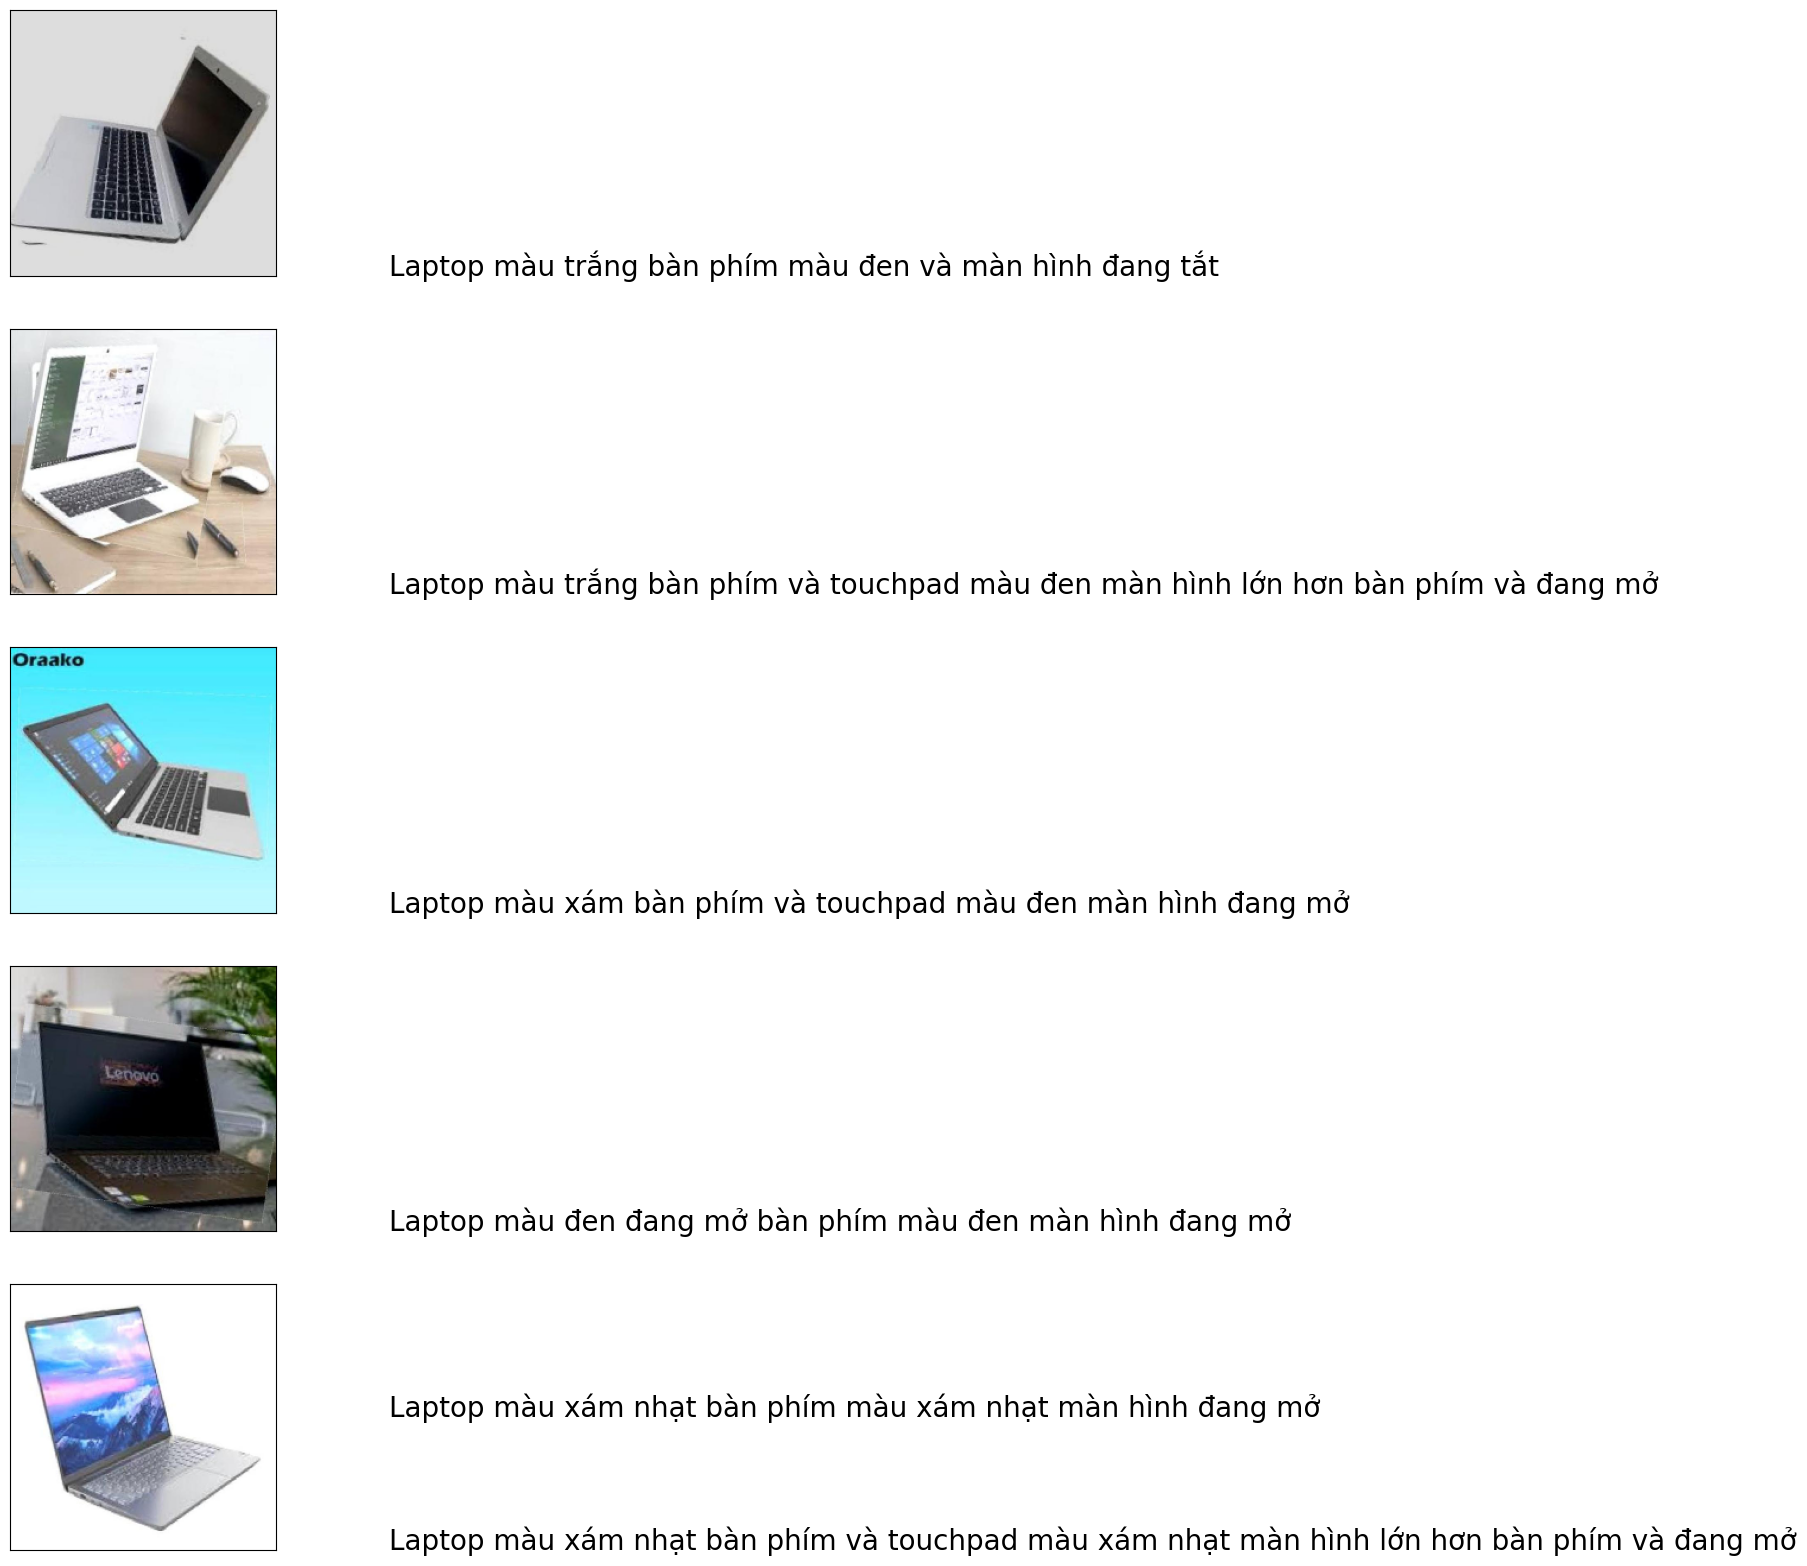

In [6]:
# Đọc dữ liệu từ tệp tin CSV "/dataset/dataset/captions.txt" và sử dụng dấu chấm phẩy ";" làm dấu phân cách.
data = pd.read_csv(caption_path, sep=";")

# Tạo danh sách các tên file ảnh duy nhất từ DataFrame data
uni_filenames = data["path"].unique()

# Tiếp tục với đoạn mã hiển thị ảnh và chú thích
npic = 5
npix = 224
target_size = (npix, npix, 3)
count = 1

fig = plt.figure(figsize=(10, 20))

for jpgfnm in uni_filenames[10:15]:
    filename = "/dataset/dataset/images/" + jpgfnm
    captions = list(data["caption"].loc[data["path"] == jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=20)
    count += 1

plt.show()


In [7]:
# Tính toán quy mô của từ vựng
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 169


In [8]:
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   data["caption"].iloc[i] = newcaption

In [9]:
# Quy mô từ vựng sau khi được "làm sạch"
clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 166


In [10]:
# Lưu tất cả các caption vào danh sách để có thể tải các ảnh cùng một lúc bằng cách sử dụng tập hợp đường dẫn
PATH = "/dataset/dataset/images/"
all_captions = []
for caption  in data["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[0:10]


['<start>  Laptop màu xám bàn phím đen và màn hình đang mở <end>',
 '<start>  Laptop màu đen bàn phím đen và màn hình đang tắt <end>',
 '<start>  Laptop màu xám đậm bàn phím màu xám đậm và màn hình đang tắt <end>',
 '<start>  Laptop màu trắng bàn phím màu xám đậm và màn hình đang tắt <end>',
 '<start>  Laptop màu xám nhạt bàn phím màu xám nhạt và màn hình đang mở <end>',
 '<start>  Laptop màu xám nhạt bàn phím màu xám nhạt và màn hình đang mở <end>',
 '<start>  Điện thoại màu trắng có nút ấn hình tròn bên dưới màn hình đang tắt <end>',
 '<start>  Chuột máy tính có màu đen có in chữ trắng dưới thiết kế nhỏ gọn <end>',
 '<start>  Laptop màu xám đậm bàn phím màu đen và màn hình đang mở <end>',
 '<start>  Laptop màu đen bàn phím màu đen có đèn LED đỏ và màn hình đang tắt <end>']

In [11]:
# Thư mục chứa tất cả tên (path) của ảnh
all_img_name_vector = []
for annot in data["path"]:
   full_image_path = PATH + annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['/dataset/dataset/images/-106-_jpg.rf.09e11feb43b148795af72557a9085984.jpg',
 '/dataset/dataset/images/-110-_jpg.rf.b5dcacbdb43b1c98d438b8c6bf6ff5d9.jpg',
 '/dataset/dataset/images/-111-_jpg.rf.fa1bc255ed40c04b43a20ebdd5c462e2.jpg',
 '/dataset/dataset/images/-112-_jpg.rf.1bdeef2c27374aa83a351f3be0ac7e92.jpg',
 '/dataset/dataset/images/-116-_jpg.rf.0256c931349527390ae308cada4ad659.jpg',
 '/dataset/dataset/images/-116-_jpg.rf.7ed403d3bc7c06499cb369ca7f56b200.jpg',
 '/dataset/dataset/images/-119-_jpg.rf.bce39b1e232f1dbecf552aa2825a5ad9.jpg',
 '/dataset/dataset/images/-119-_jpg.rf.bce39b1e232f1dbecf552aa2825a5ad9.jpg',
 '/dataset/dataset/images/-119-_jpg.rf.bce39b1e232f1dbecf552aa2825a5ad9.jpg',
 '/dataset/dataset/images/-122-_jpg.rf.237bd6611645e1d122ae9ec4b43a3931.jpg']

In [12]:
# Số lượng tên ảnh và caption
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 1640
len(all_captions) : 1640


In [13]:
def data_limiter(num,all_captions,all_img_name_vector):
   train_captions, img_name_vector = shuffle(all_captions,all_img_name_vector,random_state=1)
   train_captions = train_captions[:num]
   img_name_vector = img_name_vector[:num]
   return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(1640,all_captions,all_img_name_vector)

In [14]:
# Định nghĩa hàm để tải và xử lý hình ảnh
def load_image(image_path):
    # Đọc tệp hình ảnh từ đường dẫn được cung cấp
    img = tf.io.read_file(image_path)
    # Giải mã hình ảnh và chuyển đổi thành tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Thay đổi kích thước hình ảnh thành (299, 299)
    img = tf.image.resize(img, (299, 299))
    # Tiền xử lý hình ảnh để phù hợp với mô hình InceptionV3
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    # Trả về tensor hình ảnh đã được xử lý và đường dẫn của hình ảnh
    return img, image_path

In [15]:
# Tạo mô hình InceptionV3 để trích xuất đặc trưng của hình ảnh
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
# Nhận đầu vào mới của mô hình InceptionV3
new_input = image_model.input
# Lấy ra lớp ẩn cuối cùng của mô hình InceptionV3
hidden_layer = image_model.layers[-1].output
# Tạo một mô hình mới để trích xuất đặc trưng của hình ảnh từ mô hình InceptionV3
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


87910968/87910968 [==============================] - 0s 0us/step


In [16]:
# Tạo một danh sách các tên ảnh duy nhất và sắp xếp chúng theo thứ tự tăng dần
encode_train = sorted(set(img_name_vector))

# Tạo một tf.data.Dataset từ danh sách các tên ảnh
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

# Sử dụng hàm load_image để tải và xử lý hình ảnh cho mỗi tên ảnh trong dataset
# Đồng thời thực hiện batch hóa dataset với kích thước batch là 64
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)


In [17]:
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                                 (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())


100%|██████████| 25/25 [00:40<00:00,  1.64s/it]


In [18]:
# Số lượng từ tối đa trong tokenizer
top_k = 120

# Khởi tạo tokenizer với các tham số cụ thể
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

# Fit tokenizer trên các chú thích huấn luyện
tokenizer.fit_on_texts(train_captions)

# Chuyển đổi các câu chú thích thành chuỗi các số nguyên
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Thêm token '<pad>' vào từ điển của tokenizer và ngược lại
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Chuyển đổi các câu chú thích thành vectơ có độ dài cố định bằng cách thêm padding
train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


In [19]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [40]:
# Thiết lập BATCH_SIZE và BUFFER_SIZE cho việc xử lý dữ liệu
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# Tính toán số bước mỗi epoch dựa trên số lượng ảnh và BATCH_SIZE
num_steps = len(img_name_train) // BATCH_SIZE

# Định nghĩa hàm ánh xạ để chuyển đổi từ tên tệp ảnh thành tensor ảnh và chú thích tương ứng
def map_func(img_name, cap):
   # Đọc tensor ảnh từ tệp .npy tương ứng với tên tệp ảnh
   img_tensor = np.load(img_name.decode('utf-8')+'.npy')
   # Trả về tensor ảnh và chú thích
   return img_tensor, cap

# Tạo dataset từ tensor slices của tên tệp ảnh và chú thích
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Ánh xạ từng cặp (tên tệp ảnh, chú thích) sang (tensor ảnh, chú thích) bằng cách sử dụng hàm map_func
# Sử dụng tf.numpy_function để gọi hàm NumPy từ trong môi trường TensorFlow
# num_parallel_calls=tf.data.experimental.AUTOTUNE giúp tăng tốc quá trình xử lý
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Xáo trộn dữ liệu và chia thành các batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Tải trước dữ liệu để tăng tốc độ huấn luyện
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [41]:
# Hàm get_angles tính toán các góc dùng cho mã hóa vị trí bằng cách sử dụng công thức góc
# được định nghĩa trong bài báo "Attention is All You Need"
def get_angles(pos, i, d_model):
   # Tính toán tỷ lệ góc dựa trên vị trí và vị trí của các "dimension" trong vector đầu vào
   angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
   return pos * angle_rates

# Hàm positional_encoding_1d tạo mã hóa vị trí cho một dãy một chiều (1D)
def positional_encoding_1d(position, d_model):
   # Tính toán góc cho từng vị trí trong dãy và từng "dimension" trong vector đầu vào
   angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :],
                           d_model)
   # Biến đổi các góc thành các giá trị sin và cos
   angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
   angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
   # Tạo mã hóa vị trí dưới dạng tensor và trả về
   pos_encoding = angle_rads[np.newaxis, ...]
   return tf.cast(pos_encoding, dtype=tf.float32)

# Hàm positional_encoding_2d tạo mã hóa vị trí cho một lưới hai chiều (2D)
def positional_encoding_2d(row,col,d_model):
   assert d_model % 2 == 0
   # Tạo vector vị trí cho hàng và cột
   row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
   col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)

   # Tính toán góc cho hàng và cột
   angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
   angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)

   # Biến đổi các góc thành các giá trị sin và cos
   angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
   angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
   angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
   angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])

   # Kết hợp các vector vị trí hàng và cột để tạo mã hóa vị trí cho lưới 2D
   pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]
   return tf.cast(pos_encoding, dtype=tf.float32)


In [42]:
# Hàm tạo mask cho các token padding trong sequence
def create_padding_mask(seq):
    # Tạo mask bằng cách so sánh các phần tử của seq với 0
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # Thêm hai chiều mới để phù hợp với kích thước của attention logits
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

# Hàm tạo mask "look-ahead" để ẩn thông tin từ các token trong tương lai
def create_look_ahead_mask(size):
    # Tạo một ma trận tam giác dưới với kích thước (size, size) và giá trị True
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

# Hàm thực hiện scaled dot-product attention (Self-Attention)
def scaled_dot_product_attention(q, k, v, mask):
    # Tính ma trận attention logits bằng cách nhân q và k, sau đó chia cho căn bậc hai của chiều của k
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # Thêm mask vào ma trận attention logits nếu mask tồn tại
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # Áp dụng softmax để tính toán attention weights
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    # Tính output bằng cách nhân attention weights với v
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

# Lớp Multi-Head Attention
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    # Hàm chia input thành các đầu
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    # Hàm gọi lớp
    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]
        # Biến đổi input bằng các ma trận trọng số tương ứng
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        # Chia input thành các đầu
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # Áp dụng scaled dot-product attention
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        # (batch_size, seq_len_q, num_heads, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # Nối các đầu attention lại
        # (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # Áp dụng lớp fully connected để tạo output
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights

# Hàm feed forward network
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
            ])


In [43]:
# Lớp EncoderLayer thực hiện một lớp của encoder trong mô hình Transformer
class EncoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(EncoderLayer, self).__init__()
      # Khởi tạo lớp MultiHeadAttention và Feed Forward Network
      self.mha = MultiHeadAttention(d_model, num_heads)
      self.ffn = point_wise_feed_forward_network(d_model, dff)

      # Khởi tạo các lớp normalization và dropout
      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)

   # Phương thức call để tính toán output của mỗi lớp encoder
   def call(self, x, training, mask=None):
      # Tính toán output của MultiHeadAttention và áp dụng dropout
      attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
      attn_output = self.dropout1(attn_output, training=training)
      # Áp dụng layer normalization và residual connection
      out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

      # Tính toán output của Feed Forward Network và áp dụng dropout
      ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
      ffn_output = self.dropout2(ffn_output, training=training)
      # Áp dụng layer normalization và residual connection
      out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
      return out2

# Lớp DecoderLayer thực hiện một lớp của decoder trong mô hình Transformer
class DecoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(DecoderLayer, self).__init__()
      # Khởi tạo các lớp MultiHeadAttention, Feed Forward Network và các lớp normalization và dropout
      self.mha1 = MultiHeadAttention(d_model, num_heads)
      self.mha2 = MultiHeadAttention(d_model, num_heads)
      self.ffn = point_wise_feed_forward_network(d_model, dff)
      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)
      self.dropout3 = tf.keras.layers.Dropout(rate)

   # Phương thức call để tính toán output của mỗi lớp decoder
   def call(self, x, enc_output, training, look_ahead_mask=None, padding_mask=None):
      # Tính toán output của lớp đầu tiên của decoder sử dụng masked multi-head attention và áp dụng dropout
      attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
      attn1 = self.dropout1(attn1, training=training)
      # Áp dụng layer normalization và residual connection
      out1 = self.layernorm1(attn1 + x)

      # Tính toán output của lớp thứ hai của decoder sử dụng multi-head attention
      # với input là enc_output và áp dụng dropout
      attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
      attn2 = self.dropout2(attn2, training=training)
      # Áp dụng layer normalization và residual connection
      out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

      # Tính toán output của lớp feed forward network và áp dụng dropout
      ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
      ffn_output = self.dropout3(ffn_output, training=training)
      # Áp dụng layer normalization và residual connection
      out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

      return out3, attn_weights_block1, attn_weights_block2


In [44]:
# Lớp Encoder thực hiện việc xử lý input qua nhiều lớp EncoderLayer trong mô hình Transformer
class Encoder(tf.keras.layers.Layer):
   def __init__(self, num_layers, d_model, num_heads, dff, row_size, col_size, rate=0.1):
      super(Encoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      # Khởi tạo embedding layer và positional encoding
      self.embedding = tf.keras.layers.Dense(self.d_model, activation='relu')
      self.pos_encoding = positional_encoding_2d(row_size, col_size, self.d_model)

      # Khởi tạo các lớp EncoderLayer
      self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   # Phương thức call để tính toán output của Encoder
   def call(self, x, training, mask=None):
      seq_len = tf.shape(x)[1]
      # Embedding input và thêm positional encoding
      x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      # Truyền input qua các lớp EncoderLayer
      for i in range(self.num_layers):
         x = self.enc_layers[i](x, training, mask)

      return x  # (batch_size, input_seq_len, d_model)

# Lớp Decoder thực hiện việc xử lý input qua nhiều lớp DecoderLayer trong mô hình Transformer
class Decoder(tf.keras.layers.Layer):
   def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
      super(Decoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      # Khởi tạo embedding layer và positional encoding
      self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
      self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

      # Khởi tạo các lớp DecoderLayer
      self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   # Phương thức call để tính toán output của Decoder
   def call(self, x, enc_output, training, look_ahead_mask=None, padding_mask=None):
      seq_len = tf.shape(x)[1]
      attention_weights = {}

      # Embedding input và thêm positional encoding
      x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
      x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      # Truyền input qua các lớp DecoderLayer
      for i in range(self.num_layers):
         x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

         # Lưu trữ trọng số attention của mỗi lớp DecoderLayer
         attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
         attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

      return x, attention_weights


In [45]:
# Lớp Transformer định nghĩa kiến trúc của mô hình Transformer, bao gồm cả lớp Encoder và lớp Decoder
class Transformer(tf.keras.Model):
   def __init__(self, num_layers, d_model, num_heads, dff, row_size, col_size,
                target_vocab_size, max_pos_encoding, rate=0.1):
      super(Transformer, self).__init__()
      # Khởi tạo lớp Encoder và lớp Decoder
      self.encoder = Encoder(num_layers, d_model, num_heads, dff, row_size, col_size, rate)
      self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, max_pos_encoding, rate)
      # Lớp cuối cùng để chuyển đổi output của Decoder thành dạng one-hot vector
      self.final_layer = tf.keras.layers.Dense(target_vocab_size)

   # Phương thức call để tính toán output của mô hình
   def call(self, inp, tar, training, look_ahead_mask=None, dec_padding_mask=None, enc_padding_mask=None):
      # Quá trình mã hóa input qua lớp Encoder
      enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
      # Quá trình giải mã output từ lớp Decoder, sử dụng kết quả từ Encoder
      dec_output, attention_weights = self.decoder(
          tar, enc_output, training, look_ahead_mask, dec_padding_mask)
      # Áp dụng lớp cuối cùng để chuyển đổi output của Decoder thành dạng one-hot vector
      final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
      return final_output, attention_weights


In [46]:
# Định nghĩa hàm __call__ để tính toán learning rate theo thời gian (step) trong quá trình huấn luyện
def __call__(self, step):
    step = tf.cast(step, tf.float32)  # Ép kiểu dữ liệu của step sang float32
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    # Tính toán learning rate dựa trên step và warmup_steps
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [47]:
# Định nghĩa số lượng layer, kích thước của mỗi layer (d_model),
# kích thước của mạng feedforward (dff), số lượng head và kích thước của ma trận input (row_size x col_size)
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
# Kích thước của từ vựng đích bao gồm top_k cộng với 1 để tính toán token unkown
target_vocab_size = top_k + 1
# Tỉ lệ dropout
dropout_rate = 0.1

# Định nghĩa lớp CustomSchedule để lên lịch trình learning rate
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Ép kiểu dữ liệu của step sang float32
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        # Tính toán learning rate dựa trên step và warmup_steps
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# Khởi tạo learning rate từ lớp CustomSchedule và tối ưu hóa Adam với các tham số beta và epsilon cố định
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Định nghĩa hàm loss_function để tính toán loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))  # Tạo mask cho các phần tử khác 0 trong real
    loss_ = loss_object(real, pred)  # Tính toán loss
    mask = tf.cast(mask, dtype=loss_.dtype)  # Ép kiểu mask sang dtype của loss
    loss_ *= mask  # Áp dụng mask lên loss
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)  # Trả về giá trị trung bình của loss

# Định nghĩa các metric để đánh giá mô hình trong quá trình huấn luyện
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

# Khởi tạo mô hình Transformer
transformer = Transformer(
    num_layer, d_model, num_heads, dff, row_size, col_size, target_vocab_size,
    max_pos_encoding=target_vocab_size, rate=dropout_rate)


In [28]:
# Đường dẫn để lưu mô hình
checkpoint_path = "./transformer_checkpoint"

# Lưu trọng số của mô hình
transformer.save_weights(checkpoint_path)

# Sau khi huấn luyện, có thể tải lại mô hình từ trọng số đã lưu bằng cách sử dụng cùng kiến trúc mô hình
# Khởi tạo mô hình mới có cùng kiến trúc với mô hình đã định nghĩa
loaded_transformer = Transformer(
    num_layer, d_model, num_heads, dff, row_size, col_size, target_vocab_size,
    max_pos_encoding=target_vocab_size, rate=dropout_rate)

# Tải trọng số đã lưu vào mô hình mới
loaded_transformer.load_weights(checkpoint_path)


In [50]:
# Định nghĩa hàm tạo các mask cho quá trình giải mã
def create_masks_decoder(tar):
   # Tạo mask look-ahead để giới hạn các token được dự đoán trong tương lai
   look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
   # Tạo mask để loại bỏ các padding token trong đầu vào giải mã
   dec_target_padding_mask = create_padding_mask(tar)
   # Kết hợp hai loại mask lại với nhau
   combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
   return combined_mask

# Hàm huấn luyện một bước
@tf.function
def train_step(img_tensor, tar):
   # Tạo đầu vào thực tế cho mô hình giải mã
   tar_inp = tar[:, :-1]
   # Tạo đầu ra thực tế cho mô hình giải mã
   tar_real = tar[:, 1:]
   # Tạo mask cho quá trình giải mã
   dec_mask = create_masks_decoder(tar_inp)
   # Sử dụng GradientTape để tính toán gradient của loss function đối với các tham số huấn luyện
   with tf.GradientTape() as tape:
      # Sử dụng mô hình Transformer để dự đoán đầu ra
      predictions, _ = transformer(img_tensor, tar_inp, True, dec_mask)
      # Tính toán giá trị loss
      loss = loss_function(tar_real, predictions)

   # Tính toán gradient của loss function đối với các tham số huấn luyện và áp dụng nó bằng cách sử dụng optimizer
   gradients = tape.gradient(loss, transformer.trainable_variables)
   optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
   # Cập nhật các metric để theo dõi quá trình huấn luyện
   train_loss(loss)
   train_accuracy(tar_real, predictions)

# Vòng lặp huấn luyện qua nhiều epoch
for epoch in range(25):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    # Lặp qua từng batch dữ liệu trong dataset
    for (batch, (img_tensor, tar)) in enumerate(dataset):
        # Thực hiện một bước huấn luyện
        train_step(img_tensor, tar)

    # In ra thông tin về loss và accuracy cuối cùng của mỗi epoch
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
        epoch + 1, train_loss.result(), train_accuracy.result()))

    # In ra thời gian mất để hoàn thành một epoch
    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

# In ra accuracy cuối cùng sau tất cả các epoch
print('Final Accuracy: {:.4f}'.format(train_accuracy.result()))


Epoch 1 Loss 0.3194 Accuracy 0.4201
Time taken for 1 epoch: 13.845787763595581 secs

Epoch 2 Loss 0.2626 Accuracy 0.4286
Time taken for 1 epoch: 5.069310903549194 secs

Epoch 3 Loss 0.2606 Accuracy 0.4298
Time taken for 1 epoch: 5.438894748687744 secs

Epoch 4 Loss 0.2447 Accuracy 0.4321
Time taken for 1 epoch: 5.183658123016357 secs

Epoch 5 Loss 0.2212 Accuracy 0.4351
Time taken for 1 epoch: 5.2585084438323975 secs

Epoch 6 Loss 0.2241 Accuracy 0.4355
Time taken for 1 epoch: 5.213869094848633 secs

Epoch 7 Loss 0.2209 Accuracy 0.4343
Time taken for 1 epoch: 5.072640419006348 secs

Epoch 8 Loss 0.2043 Accuracy 0.4385
Time taken for 1 epoch: 5.1246209144592285 secs

Epoch 9 Loss 0.2011 Accuracy 0.4398
Time taken for 1 epoch: 4.95622992515564 secs

Epoch 10 Loss 0.2202 Accuracy 0.4369
Time taken for 1 epoch: 5.046870946884155 secs

Epoch 11 Loss 0.1911 Accuracy 0.4386
Time taken for 1 epoch: 4.970218658447266 secs

Epoch 12 Loss 0.1863 Accuracy 0.4401
Time taken for 1 epoch: 5.028055429

In [38]:
# Hàm evaluate để dự đoán một câu mô tả cho hình ảnh đầu vào
def evaluate(image):
   # Mở rộng kích thước của hình ảnh đầu vào và trích xuất đặc trưng của hình ảnh sử dụng model trích xuất đặc trưng
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   # Lấy token của từ bắt đầu và từ kết thúc trong từ điển tokenizer
   start_token = tokenizer.word_index['<start>']
   end_token = tokenizer.word_index['<end>']
   # Khởi tạo input của decoder với token của từ bắt đầu
   decoder_input = [start_token]
   output = tf.expand_dims(decoder_input, 0) #tokens
   result = [] #word list

   # Duyệt qua tối đa 100 bước để dự đoán một câu mô tả
   for i in range(100):
      # Tạo mask cho quá trình giải mã
      dec_mask = create_masks_decoder(output)
      # Sử dụng mô hình Transformer để dự đoán từ tiếp theo trong câu mô tả
      predictions, attention_weights = transformer(img_tensor_val, output, False, dec_mask)
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
      # Lựa chọn từ có xác suất cao nhất làm từ tiếp theo trong câu mô tả
      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      # Nếu gặp từ kết thúc thì kết thúc việc dự đoán
      if predicted_id == end_token:
         return result, tf.squeeze(output, axis=0), attention_weights
      # Thêm từ được dự đoán vào kết quả
      result.append(tokenizer.index_word[int(predicted_id)])
      # Cập nhật đầu vào của decoder bằng cách thêm từ được dự đoán vào cuối
      output = tf.concat([output, predicted_id], axis=-1)

   return result, tf.squeeze(output, axis=0), attention_weights


BLEU-1 score: 80.0
BLEU-2 score: 63.245553203367585
BLEU-3 score: 3.844335896078577e-91
BLEU-4 score: 1.1862800137389335e-152
Real Caption: camera hình hộp màu xám
Predicted Caption: camera hình nón màu xám


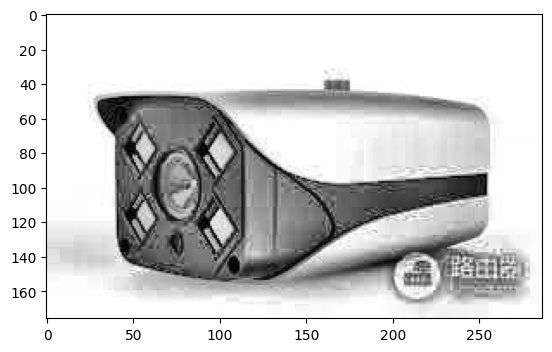

In [51]:
# Chọn ngẫu nhiên một hình ảnh từ tập validation
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
# Lấy câu mô tả thực tế từ tập dữ liệu validation
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
# Chạy hàm evaluate để dự đoán câu mô tả cho hình ảnh đã chọn
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

# Loại bỏ từ "<unk>" khỏi câu mô tả dự đoán và câu mô tả thực tế
for i in caption:
   if i=="<unk>":
      caption.remove(i)

for i in real_caption:
   if i=="<unk>":
      real_caption.remove(i)

# Ghép các từ trong câu mô tả dự đoán lại thành một chuỗi và loại bỏ từ cuối cùng
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

# Tạo danh sách từng từ trong câu mô tả thực tế
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

# Tính toán các điểm BLEU score cho các độ đo BLEU từ BLEU-1 đến BLEU-4
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)